# Constructing Hamiltonians using PySCF and OpenFermion

Here I use the PySCF results for $H_2$ molecule to construct the Hamiltonian in the second quantized form,

$$
H = \sum_{ij} h_{ij}a_i^\dagger a_j + \frac{1}{2}\sum_{pqrs} V_{pq,rs} a_p^\dagger a_q^\dagger a_r a_s.
$$

Here the indices on the Fermionic operators label orthonormal basis functions. These functions may be molecular orbitals, which is the common case, or they may be orthonormalized atomic basis functions. In either case, we use the core Hamiltonian and the 2-body integrals in the molecular orbitals computed by PySCF to supply the matrix elements in the above equation.

Note that the above labels are for the full (spin) orbital. In the case of $H_2$ molecule in the restricted Hartree-Fock calculation, there is no spin-dependence in the Hamiltonian. Therefore, we construct all the spin-conserving terms using the same coefficient for the identical combinations of spatial orbitals.


In [1]:
import numpy as np
from scipy import linalg, sparse
from itertools import product
from pyscf import gto, scf, ao2mo
import openfermionpyscf as ofpyscf
from openfermion import utils, ops
from openfermion.ops import FermionOperator
import openfermion as opf
from quantum.utils import plotting as PLT
from quantum.qprimitives import mathutils
from quantum import constants

In [2]:
def fermionic_hamiltonian(sol,X=None):
    """
    Creates the FermionOperator type Hamiltonian from the one-body and two-body integrals in PySCF.
    Includes the nuclear repulsion energy as a constant. 
    
    Args:
        sol (pyscf.scf) : self-consistent solution object
        X (np.ndarray)  : basis vectors arranged in columns
    Returns:
        H (FermionOperator) : Full Fermionic Hamiltonian 
    """
    if X is None:
        x = sol.mo_coeff
    Hcore = X.T @ sol.get_hcore() @  X
    Vtensor = ao2mo.restore(1, ao2mo.kernel(mol, X), X.shape[1]).transpose((0,2,3,1))
    
    H0 = sol.energy_nuc()
    for i,j in product([0,1],[0,1]):
       H0 += Hcore[i,j]*FermionOperator( [ (2*i,1), (2*j,0) ] )
       H0 += Hcore[i,j]*FermionOperator( [ (2*i+1,1), (2*j+1,0) ] )
    #
    Vc = 0
    for p,q,r,s in product([0,1],[0,1],[0,1],[0,1]):
        if np.abs(Vtensor[p,q,r,s])>1e-8:
            Vc += (
                Vtensor[p,q,r,s]/2*FermionOperator( ( (2*p, 1), (2*q, 1), (2*r, 0), (2*s, 0) ) ) + 
                Vtensor[p,q,r,s]/2*FermionOperator( ( (2*p, 1), (2*q+1, 1), (2*r+1, 0), (2*s, 0) ) ) + 
                Vtensor[p,q,r,s]/2*FermionOperator( ( (2*p+1, 1), (2*q, 1), (2*r, 0), (2*s+1, 0) ) ) + 
                Vtensor[p,q,r,s]/2*FermionOperator( ( (2*p+1, 1), (2*q+1, 1), (2*r+1, 0), (2*s+1, 0) ) ) 
            )
    return H0 + Vc

Build H2 molecule using the `gto` module. Solve it using the restricted Hartree Fock method.

In [3]:
bond_length = 0.7 # Angstrom
mol = gto.Mole()
mol.build(atom=f'H 0 0 {-bond_length/2};H 0 0 {bond_length/2}',basis='sto-3g',unit='A')
sol = scf.RHF(mol).run()

converged SCF energy = -1.11734903499028


Create the $\mathbf{S}^{-1/2}$ matrix for describing the Hamiltonian in terms of orthonormalized basis.

In [4]:
# Create the 
S = sol.get_ovlp()
D,U = np.linalg.eigh(S)
Shalfinv = U @ np.sqrt(np.diag(1/D)) @ U.T

In [5]:
Hfermion = fermionic_hamiltonian(sol,sol.mo_coeff)

## Directly using OpenFermion

In [6]:
# Set molecule parameters
geometry = [("H", (0.0, 0.0, -bond_length/2)), ("H", (0.0, 0.0, bond_length/2))]
hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, 'sto-3g', multiplicity=1, charge=0)
Hfermion2 = opf.get_fermion_operator(hamiltonian)

Check that the Hamiltonian we created above manually from PySCF matrices is equal to the Hamiltonian constructed by OpenFermion for the same molecule.

In [7]:
Hfermion == Hfermion2

True

## Exact diagonalization
Create the $16\times16$ Hamiltonian that arises from 4 spin orbitals (2 spatial and 2 spin) for 2 electrons.
The matrix construction works on `QubitOperator`. However, `FermionOperator` is accepted as input also, and it is first converted to `QubitOperator` via the Jordan Wigner transformation.  

In [8]:
Hmatrix = opf.linalg.get_sparse_operator(Hfermion)

The expectation value $ \langle 1 1 0 0 | H | 1 1 0 0\rangle $ must equal the HF total energy in the ground state, i.e. -1.117 Hartree as found above. Let us check that.

In [9]:
v = np.zeros(16)
i = mathutils.to_decimal(np.array([1,1,0,0]))
v[i]=1
opf.linalg.expectation(Hmatrix, v)

(-1.1173490349902795+0j)

Min(Energy) -1.1361894540659225


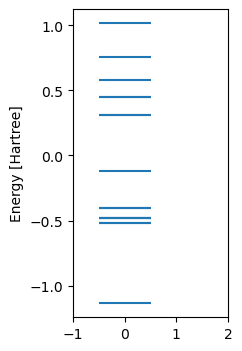

In [10]:
E,U = np.linalg.eigh(Hmatrix.toarray())
U[np.abs(U)<1e-12]=0
fig,ax=PLT.subplots(figsize=(2,4),ylabel='Energy [Hartree]')
ax.hlines(E, -0.5,0.5)
ax.set_xlim(-1,2)
print('Min(Energy)',E[0])

Let us look at the lowest energy state. We know that it is represented as

$$ \Psi = \sum_{i=0}^{15} u[i,0] |i\rangle$$

We pick the non-zero terms in the sum, and expand $|i\rangle$ into the 4-qubit space by converting each $i$ to its binary form. We know that each term in the sum above is a single Slater determinant in the Fermionic space. From the result below, we see that the dominant determinant is indeed $|1100\rangle$, but it is slightly mixed with the state $|0011\rangle$ that occupies the second spatial orbital (i.e. the anti-bonding orbital in the minimal basis of $H_2$). 

The exact diagonalization clearly produces a lower energy, and shows that the exact ground state is not Hartree Fock.

In [11]:
# Drop the zero terms
Indices = np.argwhere(np.abs(U[:,0])>0).flatten()
print('Non-zero terms',Indices)

# Convert the indices to binary form to obtain the state in the computational qubit basis
psi = [(mathutils.to_binary(i,4),U[i,0]) for i in Indices]

print('State in qubit form')
print(psi)

Non-zero terms [ 3 12]
State in qubit form
[(array([0, 0, 1, 1]), (0.10467518571066138+0j)), (array([1, 1, 0, 0]), (-0.9945064632753466+0j))]


## Fermionic Hamiltonian terms

Given a Fermionic Hamiltonian like the one we constructed above, we can get all its terms at once as a `dict`. The keys are the tuples $(i,b)$ where $i$ is the index and $b$ represents the creation $b=1$ or annihilation $b=0$ opertors. The values are the coefficients of the terms.  

In [12]:
Hfermion.terms

{((0, 1), (0, 0)): -1.2778530061568751,
 (): 0.7559674441714287,
 ((1, 1), (1, 0)): -1.2778530061568751,
 ((2, 1), (2, 0)): -0.4482996961016379,
 ((3, 1), (3, 0)): -0.4482996961016379,
 ((0, 1), (0, 1), (0, 0), (0, 0)): 0.34119476657602105,
 ((0, 1), (1, 1), (1, 0), (0, 0)): 0.34119476657602105,
 ((1, 1), (0, 1), (0, 0), (1, 0)): 0.34119476657602105,
 ((1, 1), (1, 1), (1, 0), (1, 0)): 0.34119476657602105,
 ((0, 1), (0, 1), (2, 0), (2, 0)): 0.0895002880307033,
 ((0, 1), (1, 1), (3, 0), (2, 0)): 0.0895002880307033,
 ((1, 1), (0, 1), (2, 0), (3, 0)): 0.0895002880307033,
 ((1, 1), (1, 1), (3, 0), (3, 0)): 0.0895002880307033,
 ((0, 1), (2, 1), (0, 0), (2, 0)): 0.0895002880307033,
 ((0, 1), (3, 1), (1, 0), (2, 0)): 0.0895002880307033,
 ((1, 1), (2, 1), (0, 0), (3, 0)): 0.0895002880307033,
 ((1, 1), (3, 1), (1, 0), (3, 0)): 0.0895002880307033,
 ((0, 1), (2, 1), (2, 0), (0, 0)): 0.3353663891543795,
 ((0, 1), (3, 1), (3, 0), (0, 0)): 0.3353663891543795,
 ((1, 1), (2, 1), (2, 0), (1, 0)): 0.3353

## Jordan Wigner and Bravyi-Kitaev Transforms

In [13]:
HJW = opf.jordan_wigner(Hfermion)
HBK = opf.bravyi_kitaev(Hfermion)
print(HBK)

(-0.042078976477822175+0j) [] +
(0.04475014401535165+0j) [X0 Z1 X2] +
(0.04475014401535165+0j) [X0 Z1 X2 Z3] +
(0.04475014401535165+0j) [Y0 Z1 Y2] +
(0.04475014401535165+0j) [Y0 Z1 Y2 Z3] +
(0.1777128746513992+0j) [Z0] +
(0.1777128746513992+0j) [Z0 Z1] +
(0.16768319457718972+0j) [Z0 Z1 Z2] +
(0.16768319457718972+0j) [Z0 Z1 Z2 Z3] +
(0.12293305056183809+0j) [Z0 Z2] +
(0.12293305056183809+0j) [Z0 Z2 Z3] +
(0.17059738328801052+0j) [Z1] +
(-0.24274280513140495+0j) [Z1 Z2 Z3] +
(0.17627640804319608+0j) [Z1 Z3] +
(-0.24274280513140495+0j) [Z2]


The above printed out form is fine for display. Let us look at how the `QubitOperator` is actually represented. Below we look at the attribute `terms`, which is dict with keys given by the Pauli string $((i, \hat{Q}),\ldots)$ where $i$ is the qubit index and $\hat{Q}$ is a Pauli matrix. The values are the coefficients of the Pauli string in the Hamiltonian. This is convenient to later compute expectation value of the Hamiltonian by evaluating the individual Pauli strings on a given quantum state.

In [14]:
HBK.terms

{(): (-0.042078976477822175+0j),
 ((0, 'Z'),): (0.1777128746513992+0j),
 ((0, 'Z'), (1, 'Z')): (0.1777128746513992+0j),
 ((2, 'Z'),): (-0.24274280513140495+0j),
 ((1, 'Z'), (2, 'Z'), (3, 'Z')): (-0.24274280513140495+0j),
 ((1, 'Z'),): (0.17059738328801052+0j),
 ((0, 'Y'), (1, 'Z'), (2, 'Y'), (3, 'Z')): (0.04475014401535165+0j),
 ((0, 'X'), (1, 'Z'), (2, 'X')): (0.04475014401535165+0j),
 ((0, 'X'), (1, 'Z'), (2, 'X'), (3, 'Z')): (0.04475014401535165+0j),
 ((0, 'Y'), (1, 'Z'), (2, 'Y')): (0.04475014401535165+0j),
 ((0, 'Z'), (2, 'Z')): (0.12293305056183809+0j),
 ((0, 'Z'), (2, 'Z'), (3, 'Z')): (0.12293305056183809+0j),
 ((0, 'Z'), (1, 'Z'), (2, 'Z'), (3, 'Z')): (0.16768319457718972+0j),
 ((0, 'Z'), (1, 'Z'), (2, 'Z')): (0.16768319457718972+0j),
 ((1, 'Z'), (3, 'Z')): (0.17627640804319608+0j)}

Alternatively, we can use the function `get_operators` to get each term separately as a dict. The function `get_operators` returns a list of `QubitOperators` the sum of which makes up the full Hamiltonian.

In [15]:
L = list(HBK.get_operators())
print('First 4 terms in the sum of Pauli strings representing HBK')
for i in range(4):
    print(L[i].terms)

First 4 terms in the sum of Pauli strings representing HBK
{(): (-0.042078976477822175+0j)}
{((0, 'Z'),): (0.1777128746513992+0j)}
{((0, 'Z'), (1, 'Z')): (0.1777128746513992+0j)}
{((2, 'Z'),): (-0.24274280513140495+0j)}


## Mapping Fermionic terms to Qubits

In [16]:
opf.transforms.jordan_wigner_two_body(1,2,1,2,coefficient=1)

-0.25 [] +
0.25 [Z1] +
-0.25 [Z1 Z2] +
0.25 [Z2]